## Rabi Oscillations in Isolated and Hybrid Systems

We study Rabi oscillations. First, in a single TLS. Then, we add this TLS to a graphene flake.

NOTE: this tutorial makes heavy use of the liberal way GRANAD lets you group orbitals. You might want to consult the tutorial on orbital lists first.

## Building a two-level system

Consider an isolated atom, modelled as a two-level system. Each level is an orbital, so let's combine them in a list.

In [1]:
from granad import Orbital, OrbitalList

lower_level = Orbital(tag="atom")
upper_level = Orbital(tag="atom")
atom = OrbitalList([lower_level, upper_level])

We have used a tag to signify that these the orbitals belong to the same atom. Let's see what we have done.

In [2]:
print(atom)

List with 2 orbitals, 2 electrons.
[0] electrons excited from [0] to [0].
group id 1 : 1 orbitals
group id 2 : 1 orbitals


We see that GRANAD assumes that every orbital is filled. But we want only the one of the levels filled. So, we set the electron number to 1.

In [3]:
atom.electrons = 1
print(atom)

List with 2 orbitals, 1 electrons.
[0] electrons excited from [0] to [0].
group id 1 : 1 orbitals
group id 2 : 1 orbitals


We now need to specify the Hamiltonian. We can do so by setting the elements corresponding to the orbitals.

In [4]:
atom.set_hamiltonian_element(upper_level, lower_level, 2.0)
atom.set_hamiltonian_element(upper_level, upper_level, 0.5)
atom.set_hamiltonian_element(lower_level, lower_level, -0.5)
print(atom)
print(atom.hamiltonian)

List with 2 orbitals, 1 electrons.
[0] electrons excited from [0] to [0].
group id 1 : 1 orbitals
group id 2 : 1 orbitals


[[-0.5+0.j  2. +0.j]
 [ 2. +0.j  0.5+0.j]]


Setting dipole transitions is similar. We want the lower and upper level to be connected by a dipole transition in z-direction.

In [5]:
atom.set_dipole_transition(upper_level, lower_level, [1, 0, 0])
print(atom)

List with 2 orbitals, 1 electrons.
[0] electrons excited from [0] to [0].
group id 1 : 1 orbitals
group id 2 : 1 orbitals


We set the initial excited state (in our point of view, this is a HOMO-LUMO transition).

In [6]:
atom.set_excitation(atom.homo, atom.homo + 1, 1)
print(atom)

List with 2 orbitals, 1 electrons.
[1] electrons excited from [0] to [1].
group id 1 : 1 orbitals
group id 2 : 1 orbitals


We consider a continuous wave as an external illumination.

In [7]:
from granad import Wave

wave = Wave(amplitudes=[0.05, 0, 0], frequency=2)

We propagate the system in time.

/home/david/miniconda3/lib/python3.9/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


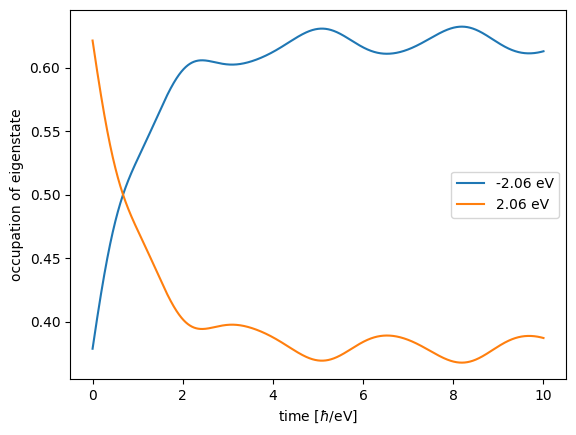

In [8]:
time, density_matrices = atom.get_density_matrix_time_domain(
    end_time=10, relaxation_rate=1, illumination=wave, use_rwa=True
)
atom.show_energy_occupations(density_matrices, time=time)

Let's try combining the TLS with a graphene flake.

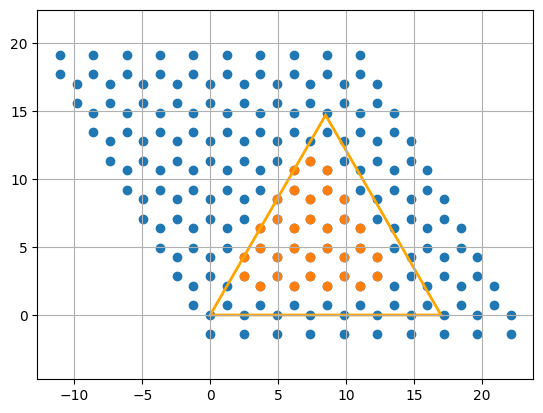

List with 35 orbitals, 35 electrons.
[0] electrons excited from [0] to [0].
group id 3 : 33 orbitals
group id 1 : 1 orbitals
group id 2 : 1 orbitals


In [9]:
from granad import Material2D, Triangle

graphene = Material2D.get("graphene")
flake = graphene.cut_orbitals(Triangle(17), plot=True)
flake_with_atom = flake + atom
print(flake_with_atom)

This looks okay, but why are we suddenly back to 1 electron per orbital? As a rule of thumb: *combining two orbital lists resets all of their attributes except for couplings*. Have a look at the OrbitalList tutorial to see why. For now, we just reduce the number of electrons by one:

In [10]:
flake_with_atom.electrons -= 1
print(flake_with_atom)

List with 35 orbitals, 34 electrons.
[0] electrons excited from [0] to [0].
group id 3 : 33 orbitals
group id 1 : 1 orbitals
group id 2 : 1 orbitals


This looks okay again. Now, we inspect the setup, displaying numbers that correspond to the index of the corresponding orbital in the list flake_with_atom

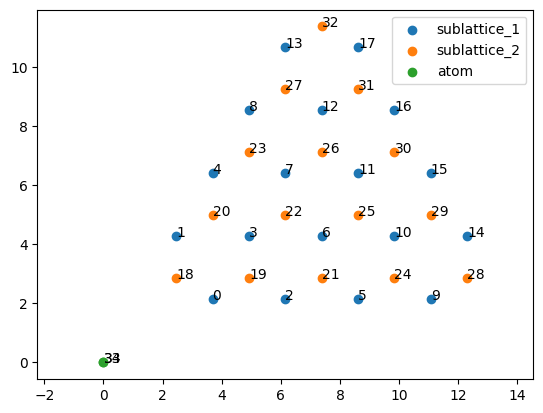

In [11]:
flake_with_atom.show_2d(show_index=True)

Let's say we want to couple the atom in the "top" position to the zeroth pz orbital in the flake, separated 1 Angström in z-direction.

In [12]:
import jax.numpy as jnp
pz_orbital = flake_with_atom[0]
translation_vector = jnp.array(pz_orbital.position) + jnp.array([0, 0, 1])
flake_with_atom.shift_by_vector(tag="atom", translation_vector=translation_vector)

Let's check if this worked

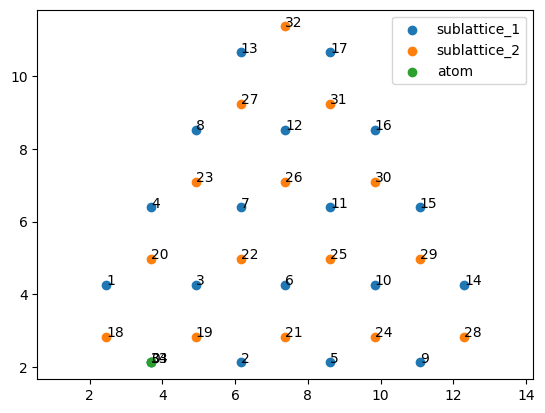

In [13]:
flake_with_atom.show_2d(show_index=True)

Now, we set the couplings between the atom and its nearest-neighbor pz Orbital.

In [14]:
flake_with_atom.set_hamiltonian_element(pz_orbital, lower_level, -2.66)
flake_with_atom.set_hamiltonian_element(pz_orbital, upper_level, -2.66)
flake_with_atom.set_coulomb_element(pz_orbital, lower_level, 14.0)
flake_with_atom.set_coulomb_element(pz_orbital, upper_level, 14.0)


What about the other orbitals? We might get away with just a nearest neighbor coupling in the Hamiltonian, but the Coulomb interaction will have more range than just the nearest neighbor.

In [15]:
flake_with_atom.set_groups_coulomb(
    upper_level, pz_orbital.group_id, lambda d: 14 / (d + 1)
)
flake_with_atom.set_groups_coulomb(
    lower_level, pz_orbital.group_id, lambda d: 14 / (d + 1)
)
print(flake_with_atom)

List with 35 orbitals, 34 electrons.
[0] electrons excited from [0] to [0].
group id 3 : 33 orbitals
group id 1 : 1 orbitals
group id 2 : 1 orbitals


/home/david/miniconda3/lib/python3.9/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


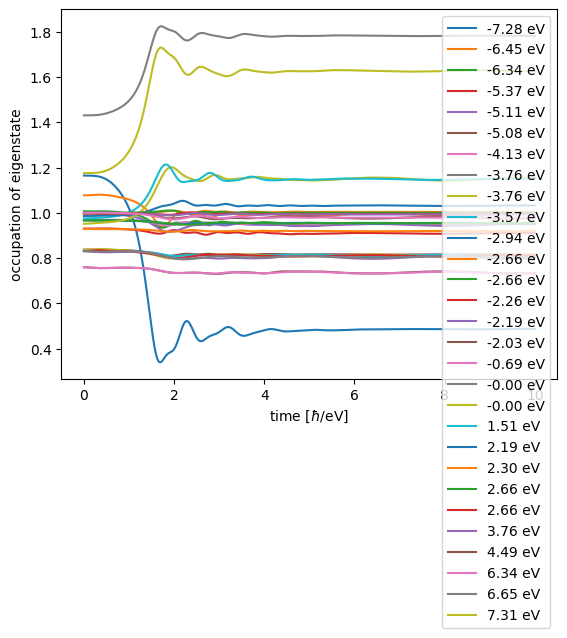

In [16]:
time, density_matrices = flake_with_atom.get_density_matrix_time_domain(
    end_time=10, relaxation_rate=1, illumination=wave
)
flake_with_atom.show_energy_occupations(density_matrices, time=time)